In [1]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [ ]:
# Load the data
gdf = gpd.read_file('final_cleaned_gdf.geojson')

# Check for missing values
print(gdf.isnull().sum())

# Replace NaN values with 'No Spill'
gdf['root_cause'] = gdf['root_cause'].fillna('No Spill')

operator_number                0
flowline_id                    0
location_id                    0
status                         0
location_type                  0
fluid                          0
material                       0
diameter_in                    0
length_ft                      0
max_operating_pressure         0
shape_length                   0
line_age_yr                    0
root_cause                274652
risk                           0
index                          0
average_pop_density           72
geometry                       0
dtype: int64


In [3]:
gdf = gdf.dropna(subset=['average_pop_density'])

# Check for missing values
print(gdf.isnull().sum())

operator_number           0
flowline_id               0
location_id               0
status                    0
location_type             0
fluid                     0
material                  0
diameter_in               0
length_ft                 0
max_operating_pressure    0
shape_length              0
line_age_yr               0
root_cause                0
risk                      0
index                     0
average_pop_density       0
geometry                  0
dtype: int64


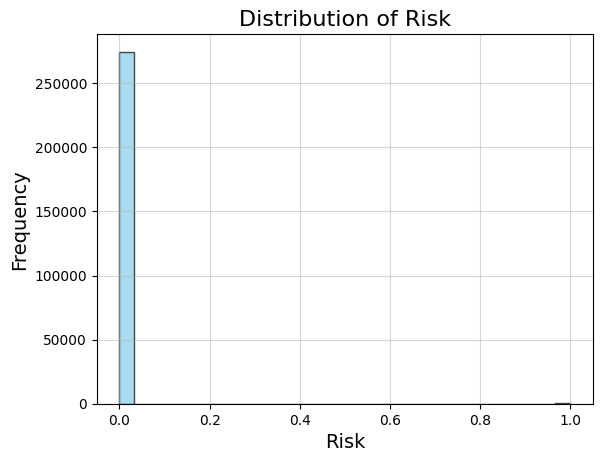

In [4]:
# Plot the distribution of the 'risk' column
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    
# Add titles and labels
plt.title('Distribution of Risk', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
    
# Show the plot
plt.show()

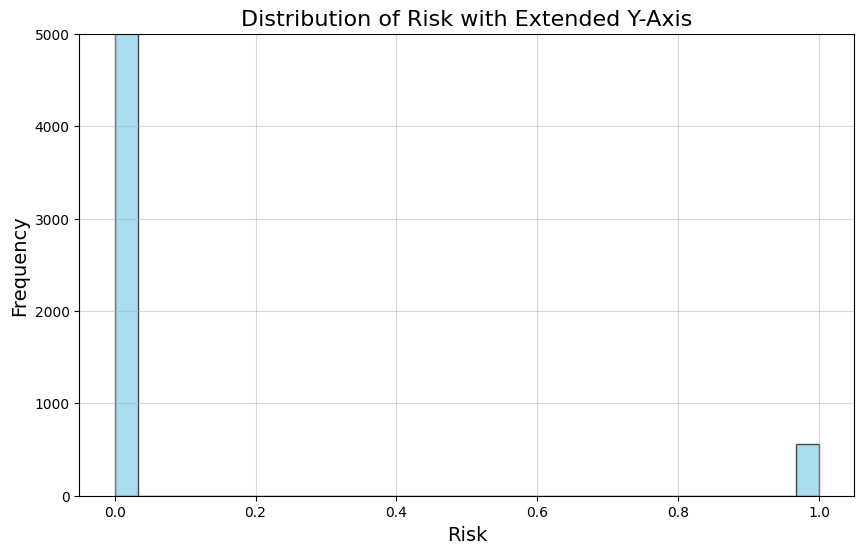

In [5]:
# Adjusting the y-axis to zoom in
plt.figure(figsize=(10, 6))

# Histogram of 'risk'
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Risk with Extended Y-Axis', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 5000)  # Adjust the y-axis to highlight risk = 1
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

In [6]:
# Count the frequency of each unique value in the 'risk' column
if 'risk' in gdf.columns:
    risk_counts = gdf['risk'].value_counts()

    # Display the counts
    print("Counts of unique risk values:")
    print(risk_counts)
else:
    print("The 'risk' column is not found in the dataset.")

Counts of unique risk values:
risk
0    274580
1       562
Name: count, dtype: int64


In [7]:
print(gdf.columns)

Index(['operator_number', 'flowline_id', 'location_id', 'status',
       'location_type', 'fluid', 'material', 'diameter_in', 'length_ft',
       'max_operating_pressure', 'shape_length', 'line_age_yr', 'root_cause',
       'risk', 'index', 'average_pop_density', 'geometry'],
      dtype='object')


In [8]:
# List of categorical variables
categorical_vars = ['status', 'location_type', 'fluid', 'material', 'root_cause', 'operator_number', 'flowline_id', 'location_id']
# List of numerical variables
numerical_vars = ['diameter_in', 'length_ft', 'max_operating_pressure',
                  'shape_length', 'line_age_yr']

# Perform one-hot encoding
gdf_encoded = pd.get_dummies(gdf, columns=categorical_vars, drop_first=True)

# Keep geometry for later use
gdf_geometry = gdf[['geometry']]

# Exclude geometry from the features
gdf_encoded = gdf_encoded.drop('geometry', axis=1)

# Define the feature matrix X and target vector y
X = gdf_encoded.drop('risk', axis=1)
y = gdf_encoded['risk']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_vars] = scaler.fit_transform(X[numerical_vars])

# Similarity Matrix

In [9]:
# Subset of instances where risk = 1
X_risk1 = X[y == 1]

# Compute cosine similarity between all instances and risk = 1 instances
similarity_matrix = cosine_similarity(X, X_risk1)

# Average similarity scores for each instance
avg_similarity = similarity_matrix.mean(axis=1)

# Convert to a DataFrame
risk_scores = pd.DataFrame({
    'avg_similarity': avg_similarity
}, index=X.index)

In [10]:
# Normalize the risk scores
min_score = risk_scores['avg_similarity'].min()
max_score = risk_scores['avg_similarity'].max()

risk_scores['risk_probability'] = (
    risk_scores['avg_similarity'] - min_score
) / (max_score - min_score)

# Assign a risk probability of 1 to all risk = 1 instances
risk_scores.loc[y == 1, 'risk_probability'] = 1.0

In [11]:
#  gdf_result is the GeoDataFrame with risk probabilities
gdf_result = gdf.join(risk_scores['risk_probability'])

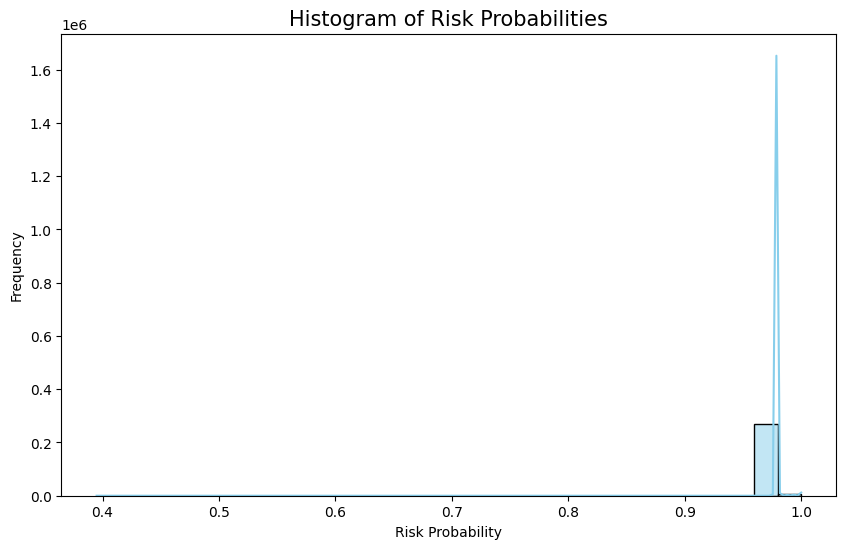

In [12]:
import seaborn as sns

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(gdf_result['risk_probability'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Histogram of Risk Probabilities', fontsize=15)
plt.xlabel('Risk Probability')
plt.ylabel('Frequency')

# Show the plot
plt.show()

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_72878/1574042676.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


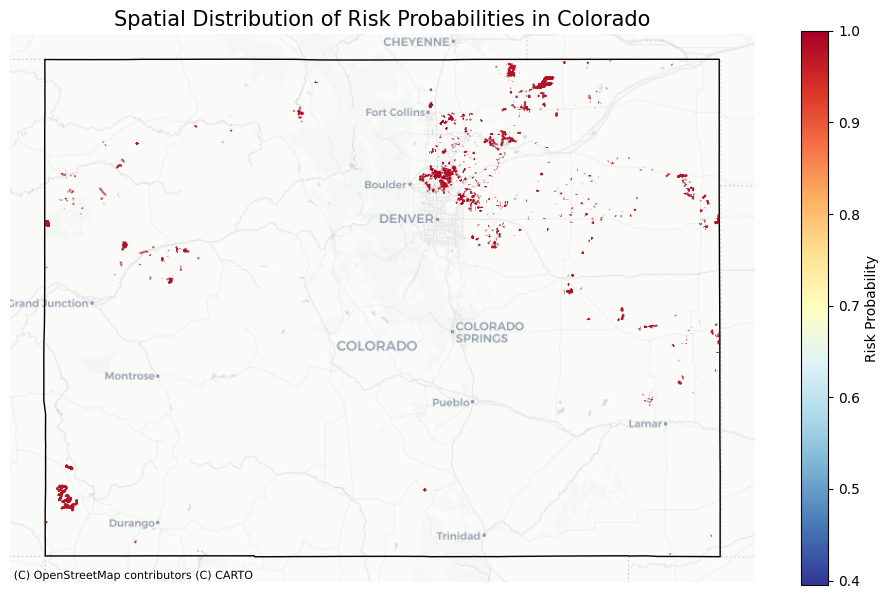

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily for basemap

# Read Colorado state boundary
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip'
states = gpd.read_file(url)
colorado = states[states['NAME'] == 'Colorado']

# Ensure CRS matches
if gdf_result.crs != colorado.crs:
    gdf_result = gdf_result.to_crs(colorado.crs)

# Clip data to Colorado
gdf_colorado = gpd.clip(gdf_result, colorado)

# Reproject to Web Mercator (EPSG:3857) for contextily
gdf_colorado = gdf_colorado.to_crs(epsg=3857)
colorado = colorado.to_crs(epsg=3857)

# Use reversed 'RdYlBu' colormap which goes from blue to red
cmap = plt.cm.get_cmap('RdYlBu_r')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Colorado boundary
colorado.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot risk probabilities
gdf_colorado.plot(
    column='risk_probability',
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        'label': "Risk Probability",
        'orientation': "vertical",
        'shrink': 0.6
    },
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axes
ax.set_title('Spatial Distribution of Risk Probabilities in Colorado', fontsize=15)
ax.set_axis_off()

# Show the plot
plt.show()

# Stats about Risk Probability

In [14]:
# Compute the mean feature vector of risk = 1 instances
X_risk1_mean = X_risk1.mean(axis=0)

In [15]:
from sklearn.preprocessing import normalize

# Convert to numpy arrays
X_array = X.values
X_risk1_mean_array = X_risk1_mean.values.reshape(1, -1)

# Normalize the feature vectors
X_normalized = normalize(X_array, axis=1)
X_risk1_mean_normalized = normalize(X_risk1_mean_array, axis=1)


KeyboardInterrupt: 

In [15]:
import numpy as np

# Compute element-wise products (feature contributions)
feature_contributions = X_normalized * X_risk1_mean_normalized

# Sum over features to get similarity scores
similarity_scores = feature_contributions.sum(axis=1)

In [16]:
# Compute average contribution of each feature across all instances
average_feature_contributions = feature_contributions.mean(axis=0)

# Create a DataFrame with feature names and their average contributions
feature_contributions_df = pd.DataFrame({
    'Feature': X.columns,
    'AverageContribution': average_feature_contributions
})

# Sort features by average contribution
feature_contributions_df = feature_contributions_df.sort_values(by='AverageContribution', ascending=False)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_5394/1321268071.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


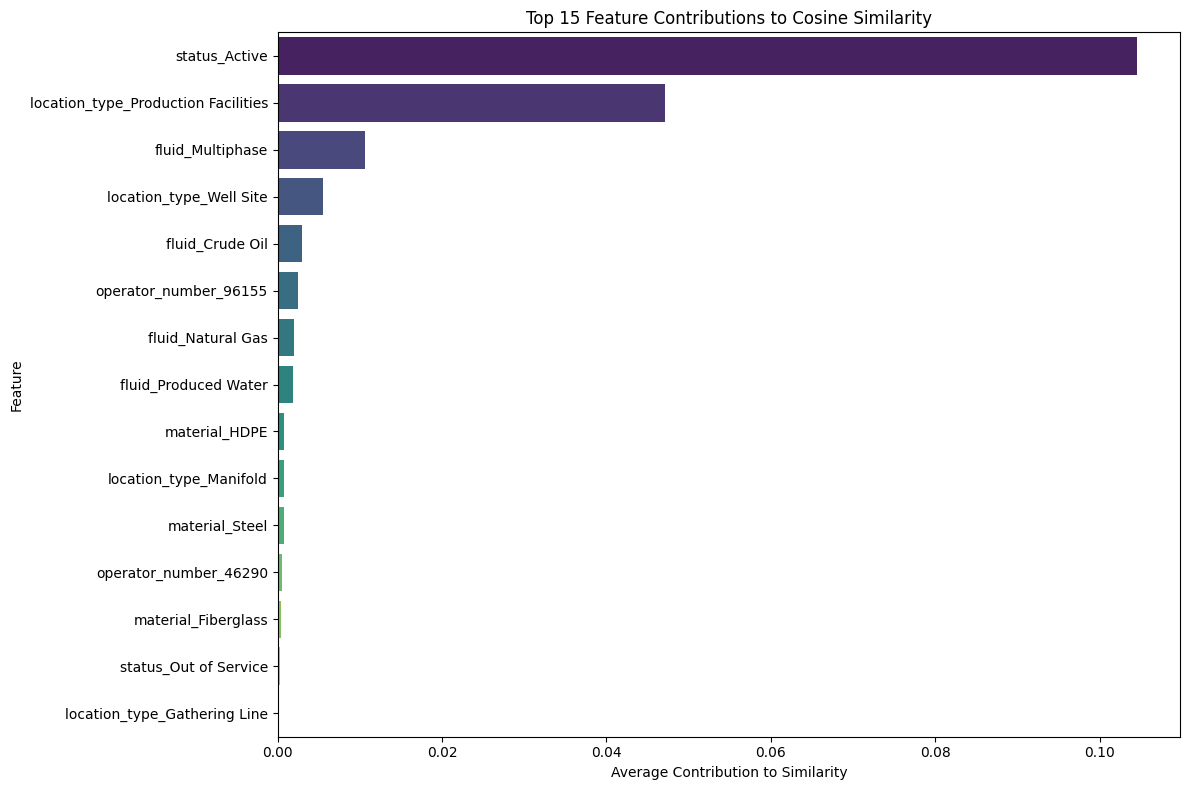

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 15 features contributing to similarity
plt.figure(figsize=(12, 8))
sns.barplot(
    x='AverageContribution',
    y='Feature',
    data=feature_contributions_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Contributions to Cosine Similarity')
plt.xlabel('Average Contribution to Similarity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Extreme Value Theory

20% of the data goes into the test set and 80% into the training set.

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(gdf_result, test_size=0.2, random_state=42)

Threshold to define what counts as an "extreme" value
-  95th percentile of the training data, all values above this threshold are considered "extreme"
-  visualize how much of the data is considered extreme

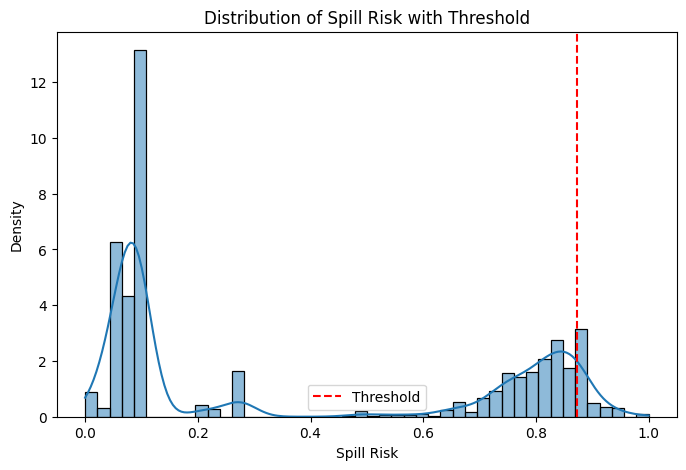

In [19]:
from scipy.stats import genextreme

threshold = train_df['risk_probability'].quantile(0.95)
extreme_values = train_df['risk_probability'][train_df['risk_probability'] > threshold]

plt.figure(figsize=(8,5))
sns.histplot(gdf_result['risk_probability'], kde=True, stat='density')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Spill Risk with Threshold')
plt.xlabel('Spill Risk')
plt.ylabel('Density')
plt.legend()
plt.show()

Fit GEV distribution

In [20]:
params = genextreme.fit(extreme_values)
shape, loc, scale = params
print("Fitted GEV parameters:")
print(f"Shape (c): {shape}, Location (loc): {loc}, Scale (scale): {scale}")

Fitted GEV parameters:
Shape (c): -0.40440931441690897, Location (loc): 0.8889874719896858, Scale (scale): 0.017117747474663922


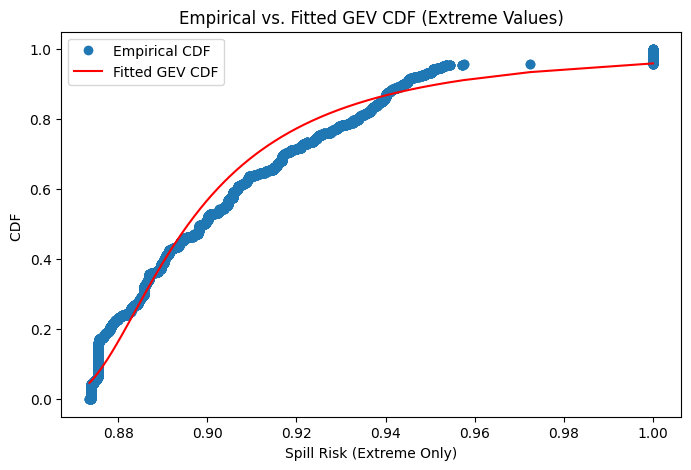

In [21]:
sorted_extremes = np.sort(extreme_values)
n = len(sorted_extremes)
empirical_cdf = np.arange(1, n+1) / (n+1)
gev_cdf = genextreme.cdf(sorted_extremes, shape, loc=loc, scale=scale)

plt.figure(figsize=(8,5))
plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
plt.title('Empirical vs. Fitted GEV CDF (Extreme Values)')
plt.xlabel('Spill Risk (Extreme Only)')
plt.ylabel('CDF ')
plt.legend()
plt.show()

R^2 (Empirical vs. Theoretical): -0.9161842874109236


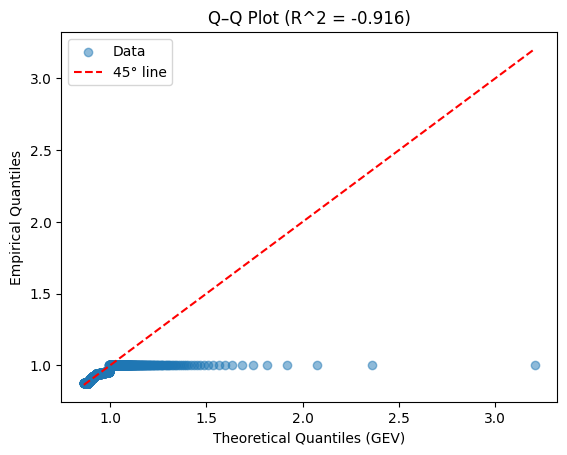

In [22]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import genextreme

# Suppose extreme_values is your array of extreme data
# and you have the fitted parameters: shape, loc, scale

# 1) Sort the observed data (empirical quantiles)
empirical_q = np.sort(extreme_values)

# 2) Compute probabilities (or plotting positions)
n = len(empirical_q)
p = (np.arange(1, n + 1) - 0.5) / n

# 3) Compute theoretical quantiles from the GEV distribution
theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

# 4) Compute R^2 using sklearn's r2_score
r2_value = r2_score(empirical_q, theoretical_q)
print("R^2 (Empirical vs. Theoretical):", r2_value)

import matplotlib.pyplot as plt

plt.scatter(theoretical_q, empirical_q, alpha=0.5, label='Data')
min_val = min(theoretical_q.min(), empirical_q.min())
max_val = max(theoretical_q.max(), empirical_q.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='45° line')

plt.title(f'Q–Q Plot (R^2 = {r2_value:.3f})')
plt.xlabel('Theoretical Quantiles (GEV)')
plt.ylabel('Empirical Quantiles')
plt.legend()
plt.show()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import genextreme
from sklearn.metrics import r2_score

def compute_r2(empirical_data, shape, loc, scale):
    """
    Compute R^2 between the sorted empirical data and the
    theoretical quantiles from a GEV distribution.
    """
    # Sort the observed data
    empirical_q = np.sort(empirical_data)
    n = len(empirical_q)
    
    # Probabilities (plotting positions)
    p = (np.arange(1, n + 1) - 0.5) / n
    
    # Theoretical quantiles from GEV
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)
    
    # Calculate R^2
    r2_val = r2_score(empirical_q, theoretical_q)
    return r2_val

def plot_qq(empirical_data, shape, loc, scale, title_suffix=''):
    """
    Plots a Q–Q plot for the provided empirical data vs. a fitted GEV.
    """
    empirical_q = np.sort(empirical_data)
    n = len(empirical_q)

    p = (np.arange(1, n + 1) - 0.5) / n
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)
    
    # R^2 for display in the plot title
    r2_val = r2_score(empirical_q, theoretical_q)

    plt.figure(figsize=(6, 5))
    plt.scatter(theoretical_q, empirical_q, alpha=0.5, label='Data', color='blue')
    
    # 45-degree line
    q_min = min(theoretical_q.min(), empirical_q.min())
    q_max = max(theoretical_q.max(), empirical_q.max())
    plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='45° line')
    
    plt.title(f'GEV Q–Q Plot {title_suffix}\n(R^2 = {r2_val:.3f})')
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.legend()
    plt.show()


In [24]:
def fit_gev_thresholds(
    df, 
    column='risk_probability',
    thresholds=[0.90, 0.95, 0.99]
):
    """
    For each threshold percentile, fit a GEV distribution to 
    values above that threshold. Compute and store R^2. 
    Return a summary DataFrame of results.
    """
    results = []
    for thresh_pct in thresholds:
        # 1. Determine numeric threshold from the percentile
        numeric_threshold = df[column].quantile(thresh_pct)
        
        # 2. Extract extreme values above that threshold
        extreme_vals = df[df[column] > numeric_threshold][column].values
        if len(extreme_vals) < 10:
            # If very few values are above the threshold,
            # skip or record with a warning
            results.append({
                'ThresholdPercentile': thresh_pct,
                'ThresholdValue': numeric_threshold,
                'NumExceedances': len(extreme_vals),
                'Shape': np.nan, 'Loc': np.nan, 'Scale': np.nan,
                'R^2': np.nan,
                'Notes': 'Too few data points to fit'
            })
            continue
        
        # 3. Fit GEV to the extreme values
        shape, loc, scale = genextreme.fit(extreme_vals)
        
        # 4. Calculate R^2
        r2_val = compute_r2(extreme_vals, shape, loc, scale)
        
        # 5. Store results
        results.append({
            'ThresholdPercentile': thresh_pct,
            'ThresholdValue': numeric_threshold,
            'NumExceedances': len(extreme_vals),
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'Notes': ''
        })
        
        # Optionally, plot Q–Q for each threshold
        title_suffix = f'(Threshold={thresh_pct}, n={len(extreme_vals)})'
        plot_qq(extreme_vals, shape, loc, scale, title_suffix=title_suffix)

    # Create a summary DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage:
# Suppose 'gdf_result' is your DataFrame with column 'risk_probability'.
# results_df = fit_gev_thresholds(gdf_result, column='risk_probability')
# print(results_df)


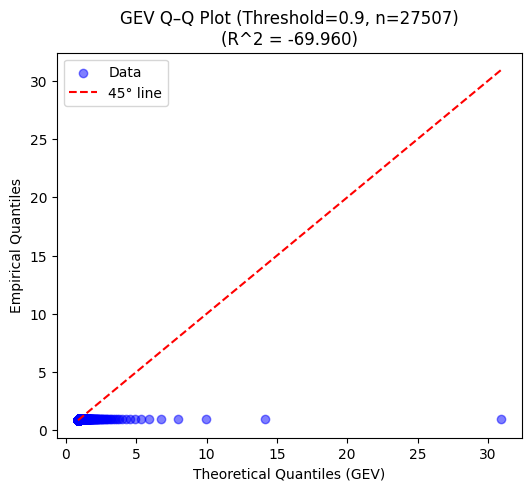

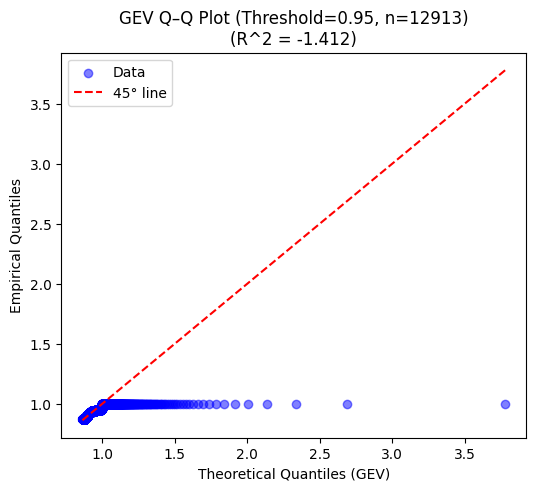

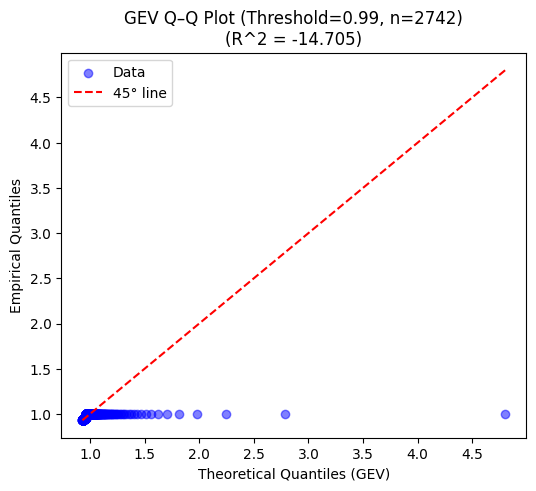

   ThresholdPercentile  ThresholdValue  NumExceedances     Shape       Loc  \
0                 0.90        0.866541           27507 -0.742335  0.873874   
1                 0.95        0.873572           12913 -0.422309  0.888740   
2                 0.99        0.931750            2742 -0.669562  0.940137   

      Scale        R^2 Notes  
0  0.006753 -69.959638        
1  0.016954  -1.412437        
2  0.008135 -14.704730        


In [25]:
results_df = fit_gev_thresholds(gdf_result, column='risk_probability')
print(results_df)



 Train–Test Split = 80%/20%
Fitted GEV Parameters:
  Shape = -0.2726
  Loc   = 11.4821
  Scale = 1.1359
  Threshold = 10.3410
Test R^2 for extremes above threshold: 0.9583


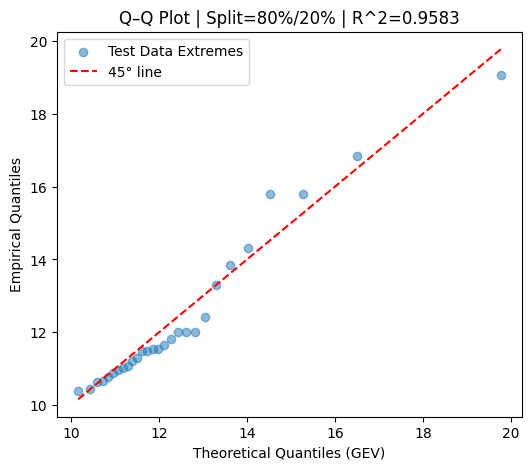


 Train–Test Split = 85%/15%
Fitted GEV Parameters:
  Shape = -0.2474
  Loc   = 11.6134
  Scale = 1.1143
  Threshold = 10.4101
Test R^2 for extremes above threshold: 0.9052


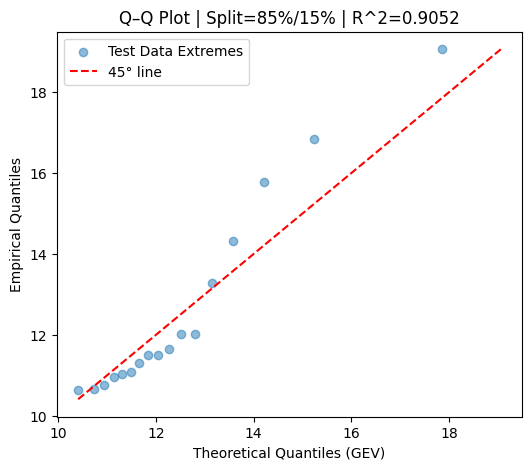


 Train–Test Split = 90%/10%
Fitted GEV Parameters:
  Shape = -0.2617
  Loc   = 11.5009
  Scale = 1.1052
  Threshold = 10.3691
Test R^2 for extremes above threshold: 0.9006


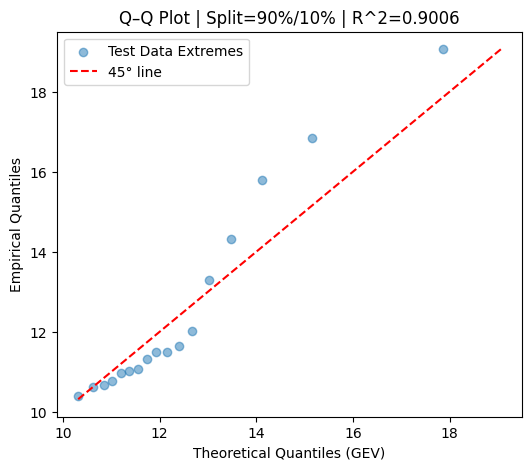


Summary of results across different splits:
   TrainSize  TestSize     Shape        Loc     Scale       R^2  NumTestExceed
0       0.80      0.20 -0.272645  11.482061  1.135943  0.958272             28
1       0.85      0.15 -0.247435  11.613391  1.114318  0.905197             17
2       0.90      0.10 -0.261710  11.500917  1.105224  0.900565             17


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import genextreme

#############################################################################
# 1. Helper Functions
#############################################################################

def fit_gev(train_data, threshold_quantile=0.95):
    """
    Fits a GEV distribution to 'train_data' above the specified
    quantile threshold (default: 95th percentile).
    Returns: (shape, loc, scale, threshold_value)
    """
    # 1) Determine threshold
    threshold_value = np.quantile(train_data, threshold_quantile)
    # 2) Extract extreme values from train_data
    train_extremes = train_data[train_data > threshold_value]
    
    if len(train_extremes) < 5:
        # Not enough data to do a reliable fit
        return None, None, None, threshold_value

    # 3) Fit the GEV distribution to these extremes
    shape, loc, scale = genextreme.fit(train_extremes)
    return shape, loc, scale, threshold_value

def compute_r2_qq(empirical_data, shape, loc, scale):
    """
    Given empirical_data (already filtered to extremes), and GEV params,
    compute the R^2 comparing empirical vs. theoretical quantiles.
    """
    if len(empirical_data) < 2:
        return None  # Can't compute R^2 with 1 or 0 data points

    sorted_empirical = np.sort(empirical_data)
    n = len(sorted_empirical)
    # Probabilities (plotting positions)
    p = (np.arange(1, n + 1) - 0.5) / n
    # Theoretical quantiles from GEV
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    # R^2
    r2_val = r2_score(sorted_empirical, theoretical_q)
    return r2_val

def plot_qq(empirical_data, shape, loc, scale, title='', alpha=0.5):
    """
    Plots Q–Q of 'empirical_data' vs. GEV(shape, loc, scale).
    """
    sorted_empirical = np.sort(empirical_data)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    # Plot
    plt.figure(figsize=(6,5))
    plt.scatter(theoretical_q, sorted_empirical, alpha=alpha, label='Test Data Extremes')
    
    # 1:1 line
    q_min = min(theoretical_q.min(), sorted_empirical.min())
    q_max = max(theoretical_q.max(), sorted_empirical.max())
    plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='45° line')
    
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title(title)
    plt.legend()
    plt.show()

#############################################################################
# 2. Main Demonstration
#############################################################################

if __name__ == '__main__':
    # ------------------------------------------------------------------------
    # A) Generate or load your data
    #    Below is an example with synthetic data. Replace with your real data.
    # ------------------------------------------------------------------------
    np.random.seed(42)
    # For illustration: some skewed / heavy-tailed data
    data = np.random.weibull(1.5, size=2000) * 5.0

    # If you have a DataFrame, e.g. df['risk_probability'],
    # you can do:
    # data = df['risk_probability'].values

    # ------------------------------------------------------------------------
    # B) Evaluate for different train–test splits
    # ------------------------------------------------------------------------
    test_sizes = [0.2, 0.15, 0.1]  # corresponds to 80/20, 85/15, 90/10
    threshold_quantile = 0.95      # 95th percentile threshold

    results = []

    for test_size in test_sizes:
        print(f"\n===============================")
        print(f" Train–Test Split = {1-test_size:.0%}/{test_size:.0%}")
        print(f"===============================")

        # 1) Split data
        train_values, test_values = train_test_split(
            data, 
            test_size=test_size, 
            random_state=42
        )

        # 2) Fit GEV on train extremes
        shape, loc, scale, thresh = fit_gev(train_values, threshold_quantile)
        if shape is None:
            print("Not enough extremes to fit GEV.")
            continue
        
        print(f"Fitted GEV Parameters:\n  Shape = {shape:.4f}\n  Loc   = {loc:.4f}\n  Scale = {scale:.4f}\n  Threshold = {thresh:.4f}")

        # 3) Evaluate on test data (above same threshold)
        test_extremes = test_values[test_values > thresh]
        if len(test_extremes) == 0:
            print("No test extremes above threshold. R^2 cannot be computed.")
            results.append({
                'TrainSize': 1 - test_size,
                'TestSize': test_size,
                'Shape': shape,
                'Loc': loc,
                'Scale': scale,
                'R^2': None,
                'NumTestExceed': 0
            })
            continue

        # 4) Q–Q Plot on test extremes
        r2_val = compute_r2_qq(test_extremes, shape, loc, scale)
        print(f"Test R^2 for extremes above threshold: {r2_val:.4f}" if r2_val else "R^2 not computed.")
        
        plot_title = f"Q–Q Plot | Split={1-test_size:.0%}/{test_size:.0%} | R^2={r2_val:.4f}"
        plot_qq(test_extremes, shape, loc, scale, title=plot_title)
        
        # 5) Store results
        results.append({
            'TrainSize': 1 - test_size,
            'TestSize': test_size,
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'NumTestExceed': len(test_extremes)
        })

    # ------------------------------------------------------------------------
    # C) Summarize your results in a DataFrame
    # ------------------------------------------------------------------------
    results_df = pd.DataFrame(results)
    print("\nSummary of results across different splits:")
    print(results_df)


In [27]:
# GEV-based cutoff at the 95th percentile
cutoff_gev = genextreme.ppf(0.95, shape, loc=loc, scale=scale)
print(f"\nGEV 95% cutoff: {cutoff_gev}")

# Actual labels (test set)
actual_labels = (test_df['risk_probability'] > threshold).astype(int)

# Predicted labels (test set)
predicted_labels = (test_df['risk_probability'] > cutoff_gev).astype(int)

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("\nConfusion Matrix (rows = Actual, cols = Predicted):")
print(cm)

# Optionally, you could visualize the confusion matrix using seaborn's heatmap:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Extreme', 'Extreme'],
            yticklabels=['Non-Extreme', 'Extreme'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


GEV 95% cutoff: 16.46580852191631


NameError: name 'confusion_matrix' is not defined

In [ ]:
# This compares the distribution of exceedances to the fitted GEV model
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(8,5))
qqplot(
    exceedances, 
    dist=genextreme,
    distargs=(shape,),   # The first argument to distargs is the shape parameter
    loc=loc,
    scale=scale,
    line='s'
)
plt.title('QQ-Plot of Exceedances (GEV)')
plt.show()

NameError: name 'exceedances' is not defined

<Figure size 800x500 with 0 Axes>

Evaluation metrics:
Accuracy: 0.6499
Precision: 0.2467
Recall: 0.1945
F1 Score: 0.2175


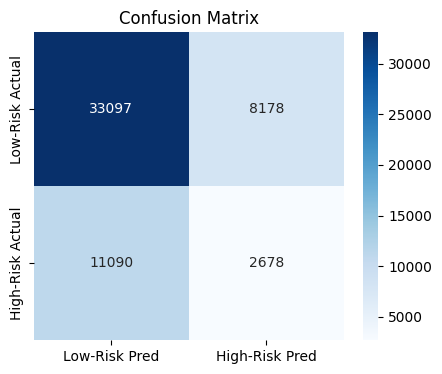

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = np.random.rand(len(test_df))
test_risks = test_df["risk_probability"]

y_true = (test_risks > 0.8).astype(int)
y_pred = (predictions > 0.8).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Evaluation metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low-Risk Pred', 'High-Risk Pred'],
            yticklabels=['Low-Risk Actual', 'High-Risk Actual'])
plt.title('Confusion Matrix')

plt.show()